## FantaSanremo 2023

Social Network, Content, and Trend analysis

Il Festival di Sanremo è sempre più social. E così, anche aziende e content creator seguono gli avvenimenti del festival per restare aggiornato su possibili trend da sfruttare e possibilità per crescere. Negli ultimi anni, il "FantaSanremo" ha spopolato tra giovani e meno giovani.

Si tratta di un gioco simile al classico e ormai popolare fantacalcio, ma incentrato proprio sul festival. Ogni partecipante sceglie una squadra composta da 5 cantanti con un massimo di 100 'bauli' (prezzo di acquisto), e - in base ai punti raccolti dalla propria squadra - compete con amici e altri in un campionato a punteggio. Per ottenere punti e riconoscimenti, i cantanti devono svolgere alcune attività presenti nel regolamento di ogni anno, senza dimenticare il festival vero e proprio, e quindi il piazzamento in classifica.

L'interesse nello svolgere questo progetto è quindi raccolto nelle seguenti domande:

- Quali sono i trend relativi a Sanremo 2023 e al FantaSanremo?
- Come possono essere sfruttati dall'azienda X e/o dall'artista Y per promuoversi (a livello di brand)
- Qual è il sentiment generale in merito al tema?
- Ѐ possibile individuare community?

Il festival è "sfruttato" dai brand per farsi conoscere e/o fidelizzare i (possibili) clienti, e dagli artisti per aumentare la propria fanbase o la propria popolarità, oltre ovviamente a competere con la propria canzone per raggiungere il successo.

Gli artisti, in particolare, guadagnano sempre più grazie agli streaming delle varie piattaforme musicali, guadagni che aumentano con il numero di ascolti delle proprie canzoni.

In [1]:
# imports

import numpy as np
import pandas as pd

import re
import string
from datetime import datetime
import time

from tqdm.notebook import tqdm
import json

#### Data

In [2]:
fantasanremo23 = pd.read_csv('../data/raw/fantasanremo2023_scraping.csv', index_col=0)

In [3]:
print(fantasanremo23.shape)
print()
print(fantasanremo23.columns)
print()

fantasanremo23.head()

(28074, 6)

Index(['date', 'id', 'content', 'username', 'like_count', 'retweet_count'], dtype='object')



,date,id,content,username,like_count,retweet_count
0,2023-02-12 23:52:01+00:00,1624919283410010112,@giovannitruppi ha interceduto per me presso l...,mg_polemos,0,0
1,2023-02-12 23:43:39+00:00,1624917176950878208,Mamma ho vinto il fantasanremo. #fantasanremo,Albos182,0,0
2,2023-02-12 23:36:19+00:00,1624915331981484032,"Non male come primo #fantasanremo , so proud o...",millenialhorror,1,0
3,2023-02-12 23:35:46+00:00,1624915193250693121,"@mengonimarco io ti amo, confidavo in te #fant...",camispadaroo,0,0
4,2023-02-12 23:30:16+00:00,1624913809243619329,Per essere il mio primo #fantasanremo direi no...,Ale89KP,3,0


Il dataset, ottenuto tramite web scraping grazie a "snscraper", è composto da poco più di 28000 righe e 6 colonne.

Il periodo di riferimento, invece, va dal 25/12/2022 al 12/02/2023. Il 25 dicembre corrisponde al giorno precedente all'annuncio dei 'bauli' (valore) necessari per acquistare ciascun cantante nella propria squadra; mentre il 12 febbraio corrisponde al giorno successivo dell'annuncio della classifica finale del FantaSanremo.

#### Data Exploration

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.text import OffsetFrom
import matplotlib.ticker as ticker

import seaborn as sns

In [5]:
fantasanremo23.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28074 entries, 0 to 28073
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           28074 non-null  object
 1   id             28074 non-null  int64 
 2   content        28074 non-null  object
 3   username       28074 non-null  object
 4   like_count     28074 non-null  int64 
 5   retweet_count  28074 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.5+ MB


In [6]:
# remove duplicates
fantasanremo23.drop_duplicates(subset ="id", inplace = True)
fantasanremo23.reset_index(drop = True, inplace = True)
fantasanremo23.shape

(28074, 6)

In [7]:
fantasanremo23['date'] = pd.to_datetime(fantasanremo23['date'])

In [8]:
fantasanremo23.dtypes

date             datetime64[ns, UTC]
id                             int64
content                       object
username                      object
like_count                     int64
retweet_count                  int64
dtype: object

In [9]:
fantasanremo23.isnull().sum()

date             0
id               0
content          0
username         0
like_count       0
retweet_count    0
dtype: int64

In [10]:
print('min date', fantasanremo23.date.min())
print('max date', fantasanremo23.date.max())

min date 2022-12-25 08:55:57+00:00
max date 2023-02-12 23:52:01+00:00


In [11]:
# change date format
day = fantasanremo23['date'].dt.day
month = fantasanremo23['date'].dt.month
year = fantasanremo23['date'].dt.year

date = year.astype(str) + month.astype(str).str.zfill(2) + day.astype(str).str.zfill(2)
date = pd.to_datetime(date, format='%Y%m%d')
fantasanremo23.drop(columns = ['date'], inplace = True)
fantasanremo23['date'] = date

# reorder columns
cols = fantasanremo23.columns.tolist()
cols = cols[-1:] + cols[:-1]
fantasanremo23 = fantasanremo23[cols].copy()

print('Tweet per day:')
print()
print(fantasanremo23.groupby('date').count()['id'].sort_values(ascending=False))

Tweet per day:

date
2023-02-07    5017
2023-02-08    4512
2023-02-09    3806
2023-02-10    3615
2022-12-27    2335
2023-02-11    2145
2023-02-12    1251
2023-02-06     866
2022-12-28     719
2022-12-26     677
2023-02-05     633
2023-01-20     236
2022-12-29     214
2023-02-04     160
2023-01-30     125
2023-01-31     101
2023-02-02      99
2023-02-03      94
2023-01-26      91
2023-02-01      84
2022-12-30      82
2023-01-22      68
2023-01-11      66
2023-01-16      63
2023-01-25      60
2023-01-15      57
2023-01-29      55
2023-01-23      54
2023-01-24      53
2023-01-27      53
2023-01-09      50
2023-01-21      49
2023-01-10      48
2023-01-28      43
2023-01-17      43
2023-01-07      40
2023-01-13      38
2023-01-05      38
2023-01-04      37
2023-01-02      37
2023-01-19      36
2022-12-31      35
2023-01-18      32
2023-01-03      31
2023-01-12      29
2023-01-08      23
2023-01-06      21
2023-01-01      21
2023-01-14      20
2022-12-25      12
Name: id, dtype: int64


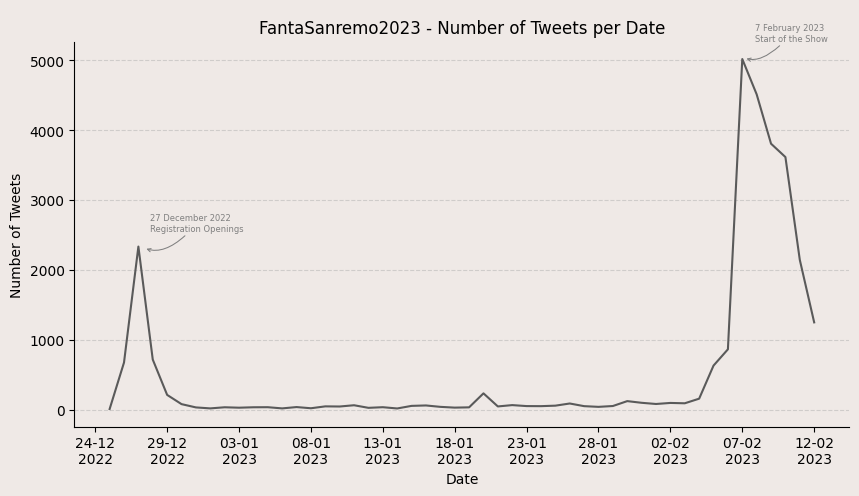

In [12]:
fig, ax = plt.subplots(1, figsize=(10,5), facecolor='#EFE9E6')
ax.set_facecolor('#EFE9E6')

plt.plot(fantasanremo23.groupby('date').id.nunique(), color='#5A5A5A')

# annotation with data coordinates and offset points
ax.annotate(
    xy = (140, 250),
    xycoords = 'figure pixels',
    xytext = (10, 15),
    textcoords = 'offset pixels',
    text = '27 December 2022\nRegistration Openings',
    size = 6,
    color = "grey",
    arrowprops = dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # arrow to connect annotation
)

# annotation with data coordinates and offset points
ax.annotate(
    xy = (740, 440),
    xycoords = 'figure pixels',
    xytext = (15, 15),
    textcoords = 'offset pixels',
    text = '7 February 2023\nStart of the Show',
    size = 6,
    color = "grey",
    arrowprops = dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # arrow to connect annotation
)

# spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# format x axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m\n%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

ax.yaxis.grid(linestyle='dashed', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('FantaSanremo2023 - Number of Tweets per Date')

plt.savefig('../figures/numTweetsDate.png', dpi=300)
plt.show()

Come possiamo osservare dalla distribuzione di tweet nei vari giorni, i giorni in cui sono stati pubblicati la maggior parte di tweet corrispondono ai giorni del festival o a giorni di annunci particolari, il 2022-12-27 è, ad esempio, il giorno di apertura delle iscrizioni per il FantaSanremo.

In [13]:
# create a DataFrame with the authors of the tweets and their respective frequency
freq_authors = fantasanremo23['username'].value_counts()
freq_authors.head()

marinodestena      228
FantaSanremo       173
gattanera130       170
DreamingGirl_QB    160
laime26412002      125
Name: username, dtype: int64

Approfondiamo ora, più nel dettaglio, i tweet risalenti al 27-12-2022.

In [14]:
# filter data
fantasanremo23_271222 = fantasanremo23[fantasanremo23.date == '2022-12-27'].copy()
fantasanremo23_271222.head()

,date,id,content,username,like_count,retweet_count
25050,2022-12-27,1607888820971896832,Sarei volentieri disposto a sacrificare 66.6 p...,fabioviola_,0,0
25051,2022-12-27,1607888514896564225,qualcuno mi spiega cos’è il #fantasanremo e co...,saraontheroad,0,0
25052,2022-12-27,1607887716435525635,"Vale, necesito que alguien me explique de qué ...",ivan_rold,0,0
25053,2022-12-27,1607887533806960640,Parlando di cose serie:\n\n#fantasanremo https...,_psychopathiic,1,0
25054,2022-12-27,1607887118906396672,fierissima della mia squadra #fantasanremo @ol...,gaiiia__,5,0


In [15]:
# number of unique tweets
fantasanremo23_271222.id.nunique()

2335

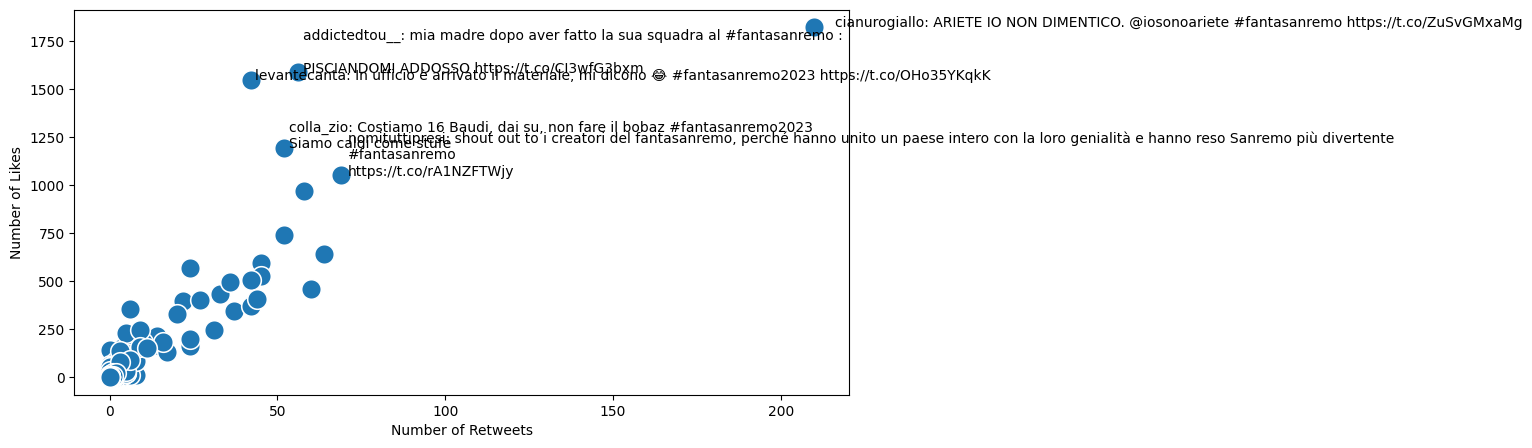

In [16]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(
    data=fantasanremo23_271222,
    x='retweet_count',
    y='like_count',
    s=200
)

for i, point in fantasanremo23_271222[
    (fantasanremo23_271222.like_count > 1000) | (fantasanremo23_271222.retweet_count > 1000)].iterrows():
    ax.text(point.retweet_count*1.03, point.like_count*1, point.username + ': ' + point.content)

ax.set_xlabel('Number of Retweets')
ax.set_ylabel('Number of Likes')
plt.savefig('../figures/scatterLikeRT.png', dpi=300)
plt.show()

#### Pre-Processing

In [17]:
import nltk

nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

from nltk import FreqDist
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from bs4 import BeautifulSoup

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\FC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
fantasanremo23['new_content'] = fantasanremo23['content'].astype(str)

# lower case
fantasanremo23['new_content'] = fantasanremo23['new_content'].str.lower()

# remove punctuation but keep hashtags
fantasanremo23['new_content'] = fantasanremo23['new_content'].str.replace(r'^\w#\s','', regex=True)

# remove stopwords
stop = stopwords.words('italian')
fantasanremo23['new_content'] = fantasanremo23['new_content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

fantasanremo23["new_content"] = fantasanremo23["new_content"].apply(lambda text: lemmatize_words(text))

# remove links
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

fantasanremo23["new_content"] = fantasanremo23["new_content"].apply(lambda text: remove_urls(text))

# remove html
def remove_html(text):
    return BeautifulSoup(text, "html.parser").text

fantasanremo23["new_content"] = fantasanremo23["new_content"].apply(lambda text: remove_html(text))

C:\Users\FC\AppData\Local\Temp\ipykernel_17888\2517431981.py:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").text


In [19]:
fantasanremo23['new_content'].head()

0    @giovannitruppi interceduto me presso divinità...
1              mamma vinto fantasanremo. #fantasanremo
2    male primo #fantasanremo , so proud of my baby...
3       @mengonimarco amo, confidavo te #fantasanremo 
4    essere primo #fantasanremo direi male no? 😅💪 @...
Name: new_content, dtype: object

In [20]:
from wordcloud import WordCloud

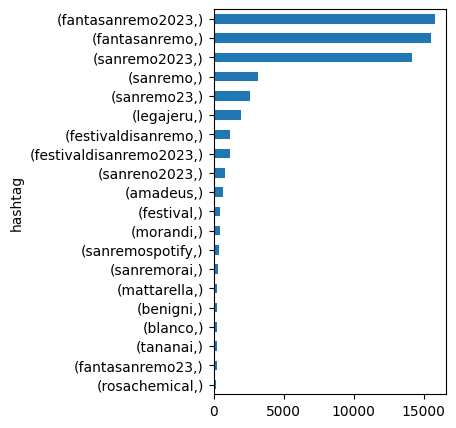

In [21]:
# hashtags
text = ' '.join(tweet for tweet in fantasanremo23.new_content)

# extract hashtags
hashtags = re.findall('#(\w+)', text)

ax = pd.DataFrame(hashtags, columns=['hashtag']).value_counts().head(20).plot(kind='barh', figsize=(3,5))
ax.invert_yaxis()

plt.savefig('../figures/hashtags.png', dpi=300, bbox_inches = "tight")
plt.show()

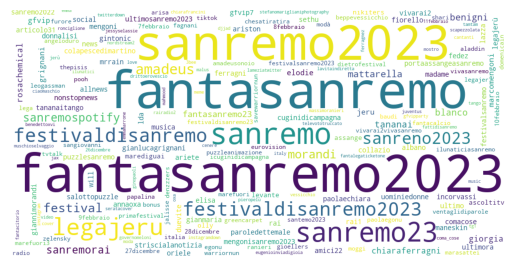

In [22]:
# generate a wordcloud for the combined text
hashtags = ' '.join(hashtag for hashtag in hashtags)

# setup, generate and save the word cloud image to a file
wc = WordCloud(
    width=1000,
    height=500,
    random_state=0,
    max_font_size=110,
    background_color='white',
    collocations=False).generate(hashtags)

wc.to_file("../figures/WordCloud_hashtags.png")

# show the wordcloud as output
plt.figure()
plt.imshow(wc)
plt.axis("off")
plt.show()

Stesso procedimento, stavolta escludendo hashtag superflui o non interessanti.

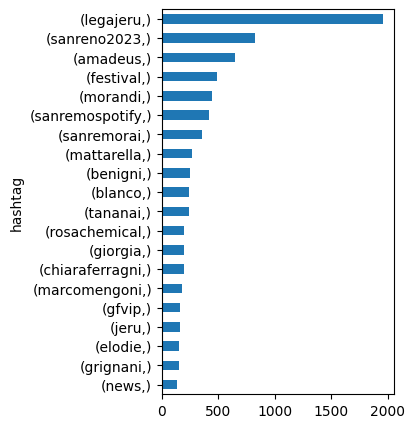

In [23]:
# hashtags
text2 = ' '.join(tweet for tweet in fantasanremo23.new_content)

# extract hashtags
hashtags2 = re.findall('#(\w+)', text2)

hashtags2 = [
    hashtag.strip() for hashtag in hashtags2 if hashtag not in
    [
        'fantasanremo2023',
        'fantasanremo',
        'sanremo2023',
        'sanremo',
        'sanremo23',
        'festivaldisanremo',
        'festivaldisanremo2023',
        'fantasanremo23'
    ]
]

ax = pd.DataFrame(hashtags2, columns=['hashtag']).value_counts().head(20).plot(kind='barh', figsize=(3,5))
ax.invert_yaxis()

plt.savefig('../figures/hashtags2.png', dpi=300, bbox_inches = "tight")

plt.show()

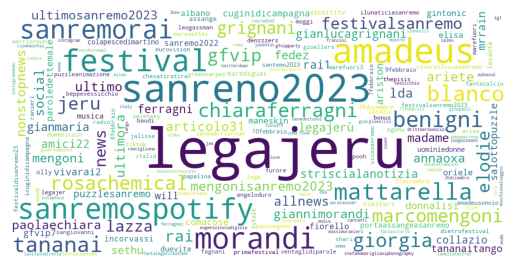

In [24]:
# generate a wordcloud for the combined text
hashtags2 = ' '.join(hashtag for hashtag in hashtags2)

# setup, generate and save the word cloud image to a file
wc = WordCloud(
    width=1000,
    height=500,
    random_state=0,
    max_font_size=110,
    background_color='white',
    collocations=False).generate(hashtags2)

wc.to_file("../figures/WordCloud_hashtags2.png")

# show the wordcloud as output
plt.figure()
plt.imshow(wc)
plt.axis("off")
plt.show()

In [25]:
fantasanremo23.to_csv('../data/fantasanremo23.csv')

#### Social Content Analysis

In [26]:
fantasanremo23_sa = fantasanremo23.copy()

_Sentiment Analysis_

twitter-XLM-roBERTa-base for Sentiment Analysis

This is a multilingual XLM-roBERTa-base model trained on ~198M tweets and finetuned for sentiment analysis. The sentiment fine-tuning was done on 8 languages (Ar, En, Fr, De, Hi, It, Sp, Pt) but it can be used for more languages.

https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

In [ ]:
# preprocess text (username and link placeholder)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)

In [ ]:
fantasanremo23_sa['scores'] = fantasanremo23_sa.content.apply(lambda x: softmax(model(**tokenizer(preprocess(x), return_tensors='pt'))[0][0].detach().numpy()))

In [ ]:
fantasanremo23_sa[['content', 'scores']].head()

In [ ]:
fantasanremo23_sa['negative'] = fantasanremo23_sa.scores.apply(lambda x: x[0])
fantasanremo23_sa['neutral'] = fantasanremo23_sa.scores.apply(lambda x: x[1])
fantasanremo23_sa['positive'] = fantasanremo23_sa.scores.apply(lambda x: x[2])

In [ ]:
fantasanremo23_sa.to_csv('../data/fantasanremo23_sa.csv')

In [27]:
fantasanremo23_sa = pd.read_csv('../data/fantasanremo23_sa.csv', index_col=0)
fantasanremo23_sa.head()

,date,id,content,username,like_count,retweet_count,new_content,scores,negative,neutral,positive
0,2023-02-12,1624919283410010112,@giovannitruppi ha interceduto per me presso l...,mg_polemos,0,0,@giovannitruppi interceduto me presso divinità...,[0.04378921 0.85044616 0.10576469],0.043789,0.850446,0.105765
1,2023-02-12,1624917176950878208,Mamma ho vinto il fantasanremo. #fantasanremo,Albos182,0,0,mamma vinto fantasanremo. #fantasanremo,[0.03423436 0.12036539 0.84540015],0.034234,0.120365,0.845400
2,2023-02-12,1624915331981484032,"Non male come primo #fantasanremo , so proud o...",millenialhorror,1,0,"male primo #fantasanremo , so proud of my baby...",[0.03642175 0.06483149 0.8987469 ],0.036422,0.064831,0.898747
3,2023-02-12,1624915193250693121,"@mengonimarco io ti amo, confidavo in te #fant...",camispadaroo,0,0,"@mengonimarco amo, confidavo te #fantasanremo",[0.01229699 0.10141013 0.886293 ],0.012297,0.101410,0.886293
4,2023-02-12,1624913809243619329,Per essere il mio primo #fantasanremo direi no...,Ale89KP,3,0,essere primo #fantasanremo direi male no? 😅💪 @...,[0.02873154 0.18579952 0.7854688 ],0.028732,0.185800,0.785469


In [30]:
# top 5 positive tweets
pd.set_option('display.max_colwidth', None)

fantasanremo23_sa_sorted_pos = fantasanremo23_sa.sort_values('positive', ascending=False)
top5_pos = fantasanremo23_sa_sorted_pos.content.head(5)
print(top5_pos)

174                       @lundiniooc @FantaSanremo Onorato per questa vittoria nella migliore lega del #fantasanremo2023!La dedico a @FanelliEmanuela, portafortuna infallibile, e a @valeriolundini, muso ispiratore🥂 https://t.co/aCstHYyCaz
6789                                                                                                             @gIANMARIAAAAA un pezzo bello, orecchiabile e.... tante soddisfazioni al #fantasanremo2023 giusto @FantaSanremo \n#Sanremo2023
196      Un GRAZIE immenso agli amici del @FantaSanremo che in questa settimana mi hanno tenuto compagnia,fatto divertire e vivere belle emozioni,siete meravigliosi e fate un lavoro immenso GRAZIE.\nA presto\n#fantasanremo2023 \n#sanremo23
12527                                                                                    @MRRAINOFFICIAL @FantaSanremo Io lo sapevo che mi avresti dato soddisfazioni al #fantasanremo2023 \nIn piu mi hai fatto salire emozioni. Bravooooooooo
15759                                   

In [31]:
# top 5 negative tweets
pd.set_option('display.max_colwidth', None)

fantasanremo23_sa_sorted_neg = fantasanremo23_sa.sort_values('negative', ascending=False)
top5_neg = fantasanremo23_sa_sorted_neg.content.head(5)
print(top5_neg)

3699     Su De André è stata fatta una porcheria, che poi va beh che cazzo ti salta in mente di portare Faber. Se avete anche solo lontanamente apprezzato sta schifezza evidentemente non conoscete ne Fabrizio ne questa canzone. Che schifo. #Fantasanremo #Sanremo2023
3327                                                                                              Ma questo #fantasanremo2023  è una noia mortale … tutti i cantanti ridotti a fare le stesse cose il bacio il regalo i ringraziamenti i fiori regalati … davvero noioso!!
22409                                                       Mi viene da vomitare solo sentire nominare la parola #fantasanremo. \nMannaggia a Twitter che ogni cosa te la fa uscire dagli occhi, porca troia. \nPure #Sanremo2023 hanno dovuto rovinare. #fantasanremo2023
2546                                                                            Ultimo avviso per MIO CUGGINO...su quel palco hai salutato il cane, il canarino e so chi altro...dire TAM TAM ti fa sch

In [33]:
fantasanremo23_sa_mean_scores = fantasanremo23_sa[['negative', 'neutral', 'positive']].mean().reset_index()
fantasanremo23_sa_mean_scores.columns = ['score_type', 'score_value']
fantasanremo23_sa_mean_scores.head()

,score_type,score_value
0,negative,0.288362
1,neutral,0.361388
2,positive,0.350250


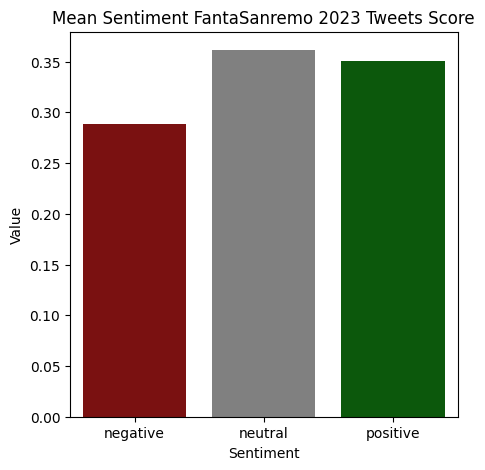

In [35]:
plt.figure(figsize=(5,5))
ax = sns.barplot(
    data=fantasanremo23_sa_mean_scores,
    x='score_type',
    y='score_value',
    palette=['darkred', 'grey', 'darkgreen']
)

ax.set_title('Mean Sentiment FantaSanremo 2023 Tweets Score')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Value')

plt.savefig('../figures/sentiment_mean.png', dpi=300, bbox_inches = "tight")
plt.show()

In [55]:
def assign_sentiment_label(row):
    if row['positive'] > row['neutral'] and row['positive'] > row['negative']:
        return 'positive'
    elif row['neutral'] > row['negative']:
        return 'neutral'
    else:
        return 'negative'

In [56]:
fantasanremo23_sa['sentiment_label'] = fantasanremo23_sa.apply(assign_sentiment_label, axis=1)

In [59]:
fantasanremo23_sa.head()

,date,id,content,username,like_count,retweet_count,new_content,scores,negative,neutral,positive,sentiment_label
0,2023-02-12,1624919283410010112,@giovannitruppi ha interceduto per me presso le divinità del #fantasanremo2023 https://t.co/rYuKNcNLDR,mg_polemos,0,0,@giovannitruppi interceduto me presso divinità #fantasanremo2023,[0.04378921 0.85044616 0.10576469],0.043789,0.850446,0.105765,neutral
1,2023-02-12,1624917176950878208,Mamma ho vinto il fantasanremo. #fantasanremo,Albos182,0,0,mamma vinto fantasanremo. #fantasanremo,[0.03423436 0.12036539 0.84540015],0.034234,0.120365,0.845400,positive
2,2023-02-12,1624915331981484032,"Non male come primo #fantasanremo , so proud of my babies ♥️ scelti in base all’amore che provavo per loro + Olly che non conoscevo ma vbb https://t.co/K6lnhHCswY",millenialhorror,1,0,"male primo #fantasanremo , so proud of my baby ♥️ scelti base all’amore provavo + olly conoscevo vbb",[0.03642175 0.06483149 0.8987469 ],0.036422,0.064831,0.898747,positive
3,2023-02-12,1624915193250693121,"@mengonimarco io ti amo, confidavo in te #fantasanremo https://t.co/fCWOf1RI2l",camispadaroo,0,0,"@mengonimarco amo, confidavo te #fantasanremo",[0.01229699 0.10141013 0.886293 ],0.012297,0.101410,0.886293,positive
4,2023-02-12,1624913809243619329,Per essere il mio primo #fantasanremo direi non male no? 😅💪 @FantaSanremo #Sanremo2023 https://t.co/Vm9etXwnx7,Ale89KP,3,0,essere primo #fantasanremo direi male no? 😅💪 @fantasanremo #sanremo2023,[0.02873154 0.18579952 0.7854688 ],0.028732,0.185800,0.785469,positive


In [60]:
fantasanremo23_sa['sentiment_label'] = pd.Categorical(fantasanremo23_sa.sentiment_label)

In [61]:
fantasanremo23_sa.dtypes

date                 object
id                    int64
content              object
username             object
like_count            int64
retweet_count         int64
new_content          object
scores               object
negative            float64
neutral             float64
positive            float64
sentiment_label    category
dtype: object

positive    10196
neutral     10115
negative     7763
Name: sentiment_label, dtype: int64


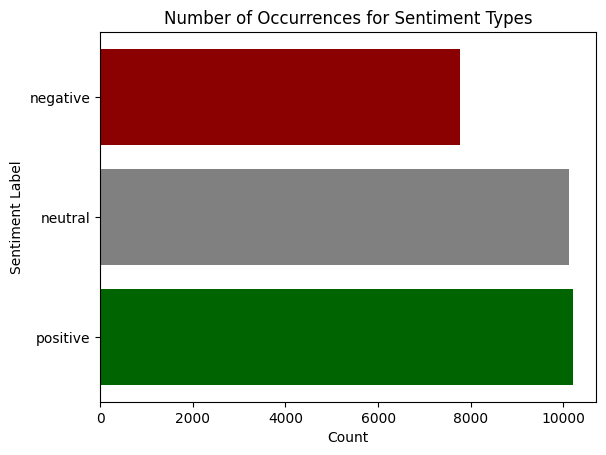

In [73]:
# count the number of occurrences of each label
counts = fantasanremo23_sa['sentiment_label'].value_counts()
print(counts)

# define a list of colors for the bars
colors = ['darkgreen', 'grey', 'darkred']

plt.barh(counts.index, counts.values, color=colors)

# add labels and title
plt.xlabel('Count')
plt.ylabel('Sentiment Label')
plt.title('Number of Occurrences for Sentiment Types')

# save figure
plt.savefig('../figures/sentiment_frequencies.png', dpi=300, bbox_inches = "tight")

plt.show()

#### Social Network Analysis

In [74]:
fantasanremo23_sn = fantasanremo23.copy()

In [75]:
# extract user mentions
fantasanremo23_sn['user_mentions'] = fantasanremo23_sn['content'].str.extract('@(\S+)')

In [76]:
fantasanremo23_sn['user_mentions']

0        giovannitruppi
1                   NaN
2                   NaN
3          mengonimarco
4          FantaSanremo
              ...      
28069               NaN
28070               NaN
28071               NaN
28072               NaN
28073               NaN
Name: user_mentions, Length: 28074, dtype: object

In [77]:
# lower case
fantasanremo23_sn['user_mentions'] = fantasanremo23_sn['user_mentions'].str.lower()

# define a string of punctuation characters to remove
punctuation = string.punctuation

# Use str.rstrip to remove punctuation from the end of the "text" column
fantasanremo23_sn['user_mentions'] = fantasanremo23_sn['user_mentions'].str.rstrip(punctuation)

In [78]:
fantasanremo23_sn.to_csv('../data/fantasanremo23_sn.csv')

In [79]:
author_mentions = fantasanremo23_sn[['username', 'user_mentions']]
author_mentions.head()

,username,user_mentions
0,mg_polemos,giovannitruppi
1,Albos182,NaN
2,millenialhorror,NaN
3,camispadaroo,mengonimarco
4,Ale89KP,fantasanremo


In [80]:
author_mentions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28074 entries, 0 to 28073
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       28074 non-null  object
 1   user_mentions  5021 non-null   object
dtypes: object(2)
memory usage: 438.8+ KB


#### Key Takeaways

- I picchi si sono registrati nel giorno dell'annuncio dell'apertura delle iscrizioni al FantaSanremo e nei giorni di gara.
- Gli hashtags più utilizzati tra i tweet relativi al #FantaSanremo 2023 riguardano i presentatori, gli ospiti e i cantanti in gara. Non mancano eccezioni come le leghe più popolari o il GF-vip, in onda nel periodo considerato.
- Per quanto riguarda il sentiment, i tweet relativi al FantaSanremo sono perlopiù neutrali e positivi.